In [1]:
import time
import warnings
import pymc3 as pm
import numpy as np
import arviz as az
import theano.tensor as tt
import matplotlib.pyplot as plt
from sampling_utils import define_model_x, define_model_xi, sample_model
from reading_utils import read_data, read_and_prepare_data, read_config
from plotting_utils import trace_plot, plotting_x
from anlaysing_utils import thinning
import corner
from plotting_utils import appendix_plots


# read text file
file_path = 'lighthouse_flash_data.txt'

Multiprocess sampling (8 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 8 chains for 800 tune and 30_000 draw iterations (6_400 + 240_000 draws total) took 23 seconds.


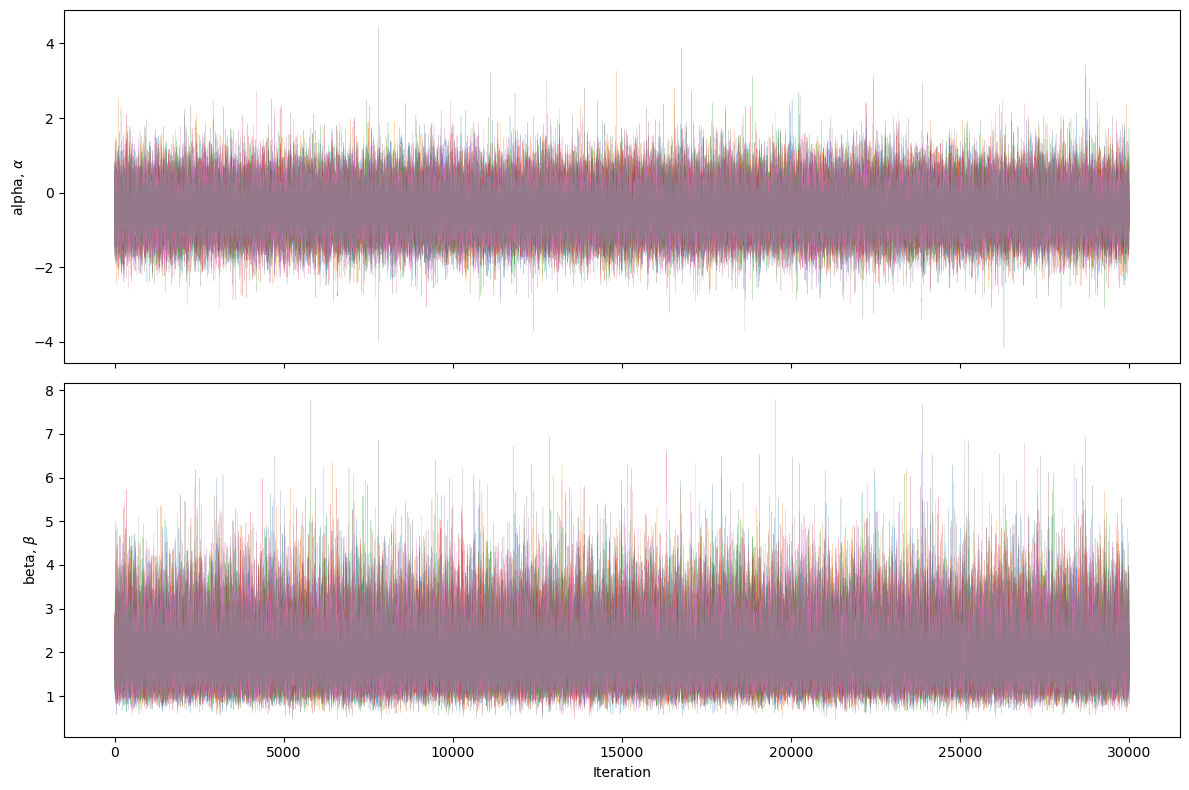

In [2]:
# Read and prepare the data
x_observed, I_observed = read_and_prepare_data('lighthouse_flash_data.txt')

# Read the configuration file
model_params, sampling_params = read_config('parameters.ini')

# Define the models
model_x = define_model_x(x_observed, **model_params)
model_xi = define_model_xi(x_observed, I_observed, **model_params)

# Sample the models
trace_x = sample_model(model_x, **sampling_params)
#trace_xi = sample_model(model_xi, **sampling_params)

# Trace plot
trace_plot(trace_x)
#trace_plot(trace_xi)

# Thinning
#thinned_trace_x = thinning(trace_xi)

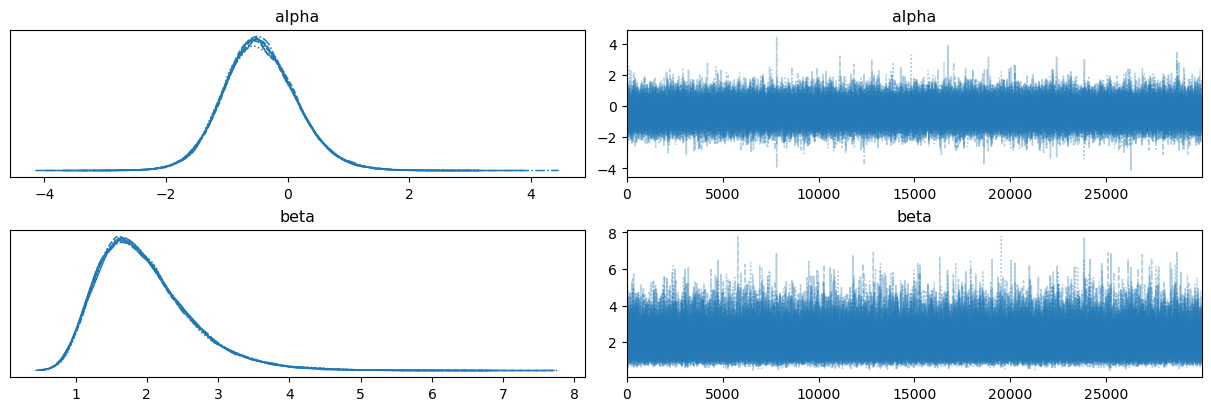

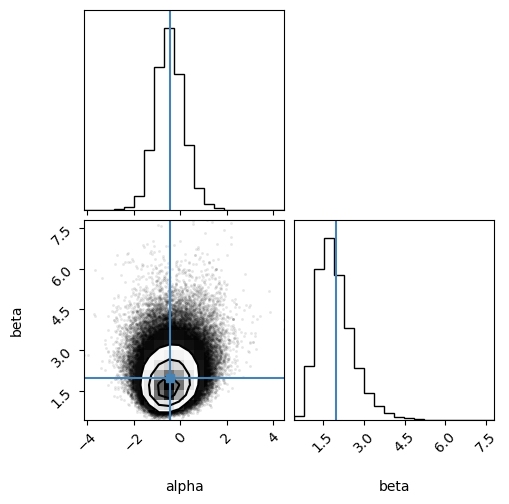

In [3]:
appendix_plots(trace_x)

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

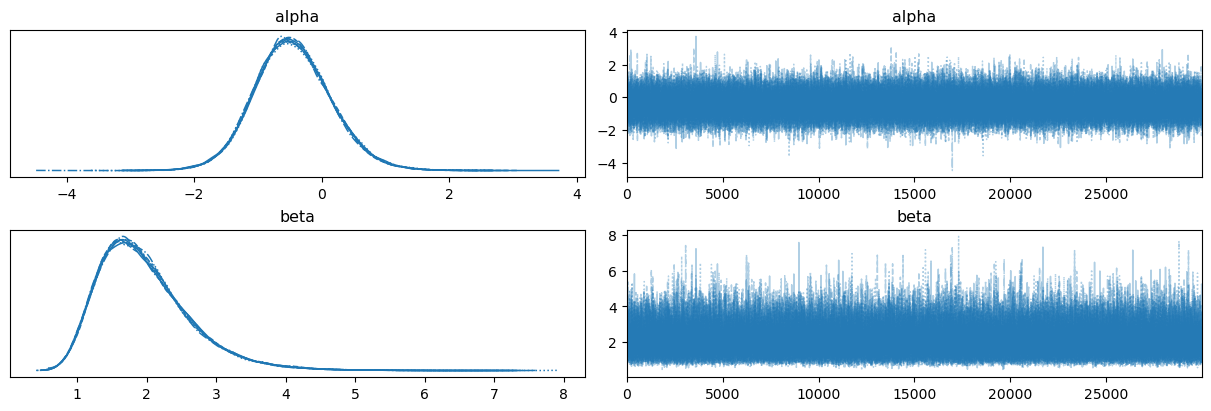

In [47]:
az.plot_trace(trace_x.posterior)

array([[<Axes: ylabel='alpha'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='alpha', ylabel='I0'>, <Axes: xlabel='beta'>,
        <Axes: xlabel='I0'>]], dtype=object)

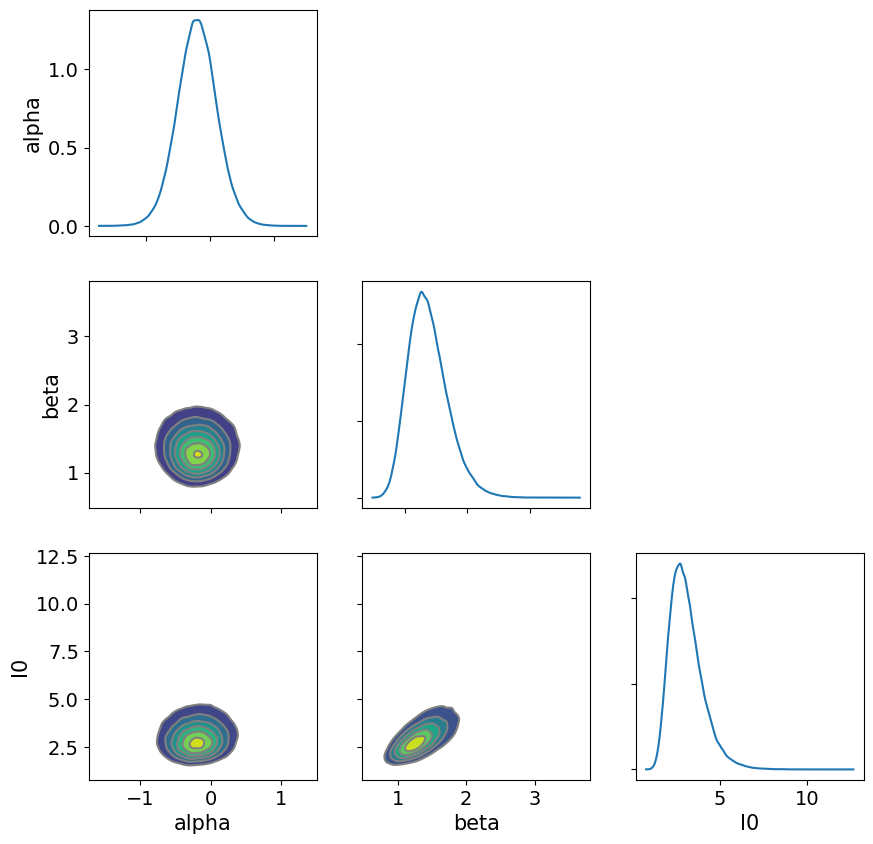

In [56]:
az.plot_pair(trace_xi, var_names=['alpha', 'beta', 'I0'], 
             kind='kde',  # Choose 'kde' for Kernel Density Estimate or 'scatter' for scatter plots
             marginals=True,  # If you want marginal distributions on the diagonal
             figsize=(10, 10))  

In [66]:
summary_stats['mean']

alpha   -0.45
beta     1.97
Name: mean, dtype: float64

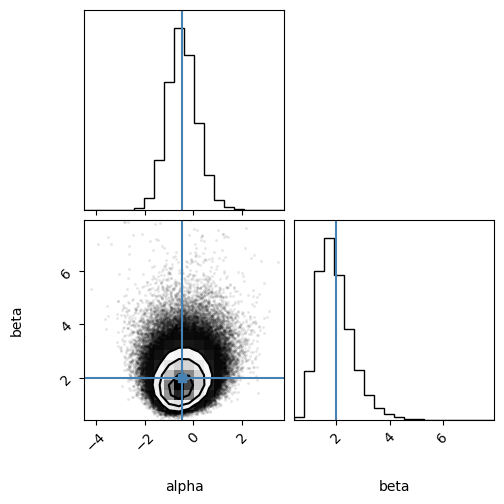

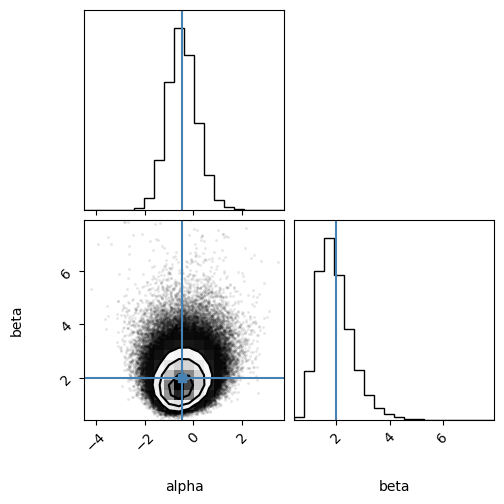

In [67]:
summary_stats = az.summary(trace_x, round_to=2)
corner.corner(trace_x, truths=summary_stats['mean'])

In [29]:
from scipy.stats.mstats import winsorize
log_I_observed = np.log(I_observed)

trim_proportion = 0.05
winsorized_data = winsorize(log_I_observed, limits=[trim_proportion, trim_proportion])

# Calculate the standard deviation of the winsorized data
winsorized_std_corrected = np.std(winsorized_data)

winsorized_std_corrected


1.9644169

In [23]:
I0_med = np.median(np.log(I_observed))
I0_std = np.std(np.log(I_observed))
I0_mean = np.mean(np.log(I_observed))

I0_std

2.1618881

In [11]:
I_observed

array([1.0139301e-01, 2.0856154e-01, 1.4923667e+00, 3.9160619e+00,
       1.4771547e+00, 2.0880377e-01, 5.5838186e-01, 1.4037808e-03,
       2.8152752e+00, 9.5773596e-01, 4.1047755e-01, 2.1338193e+00,
       4.7603765e-01, 1.0590165e+00, 2.1839063e-01, 2.3395808e-01,
       9.3393596e-03, 4.1683564e-01, 7.6124558e+00, 5.1688463e-03],
      dtype=float32)

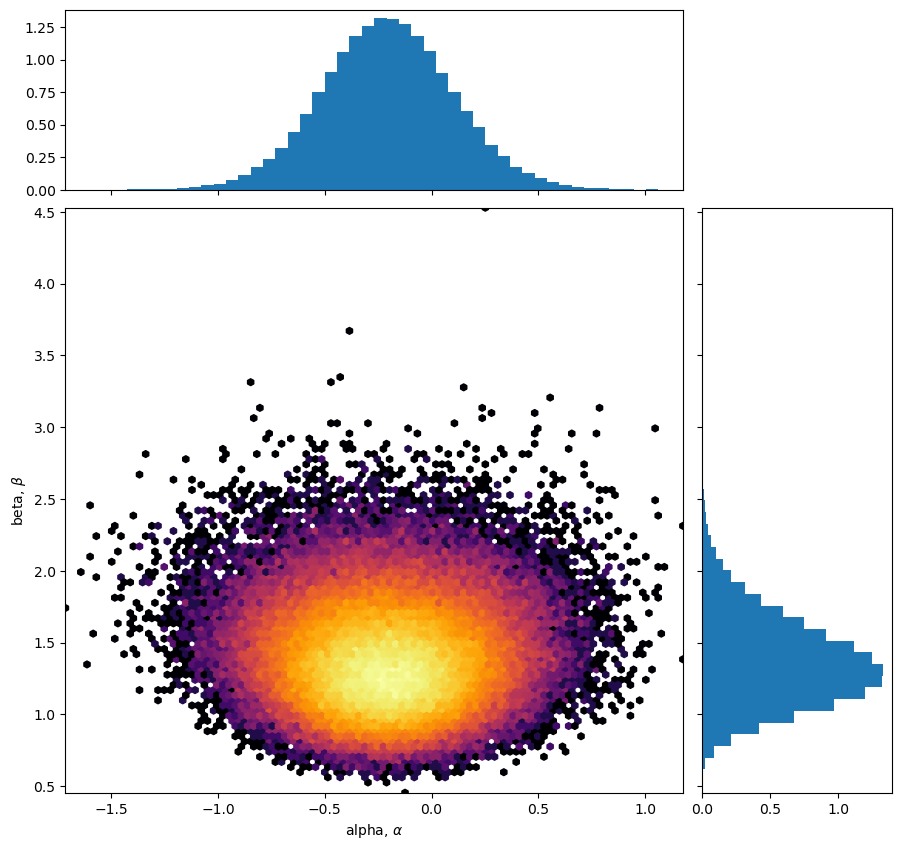

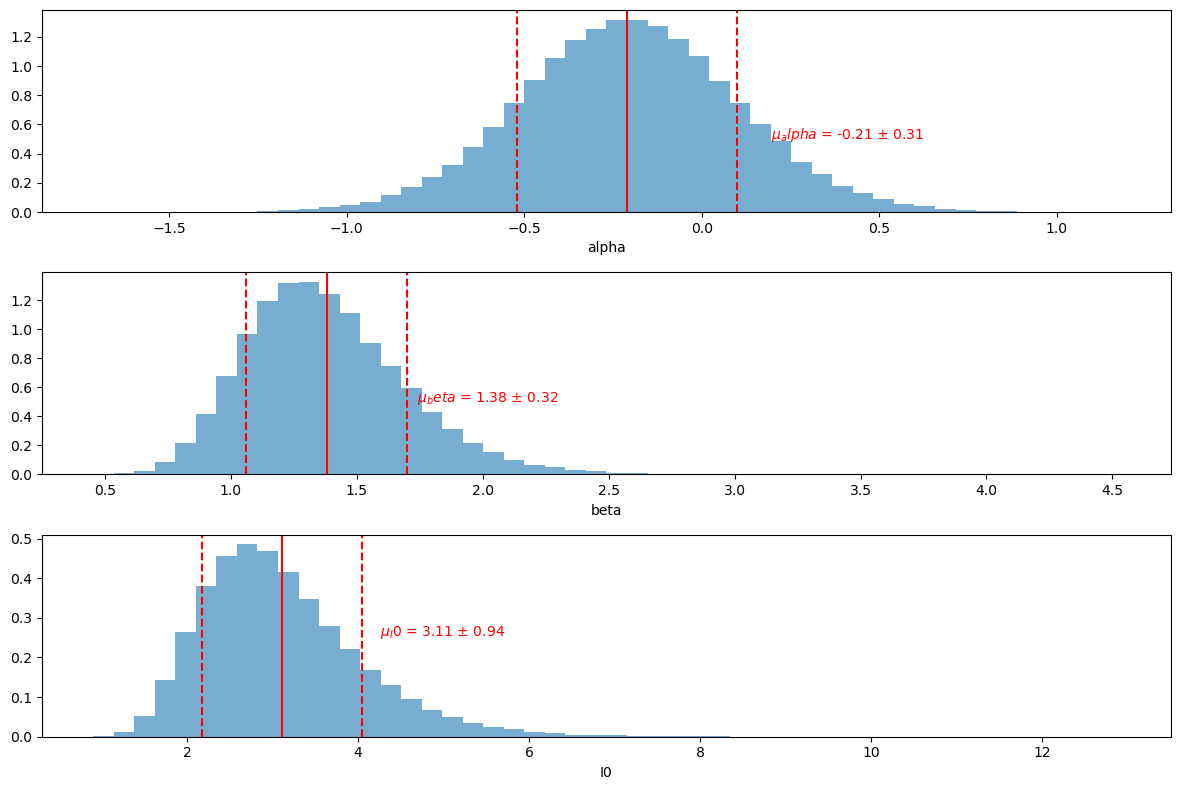

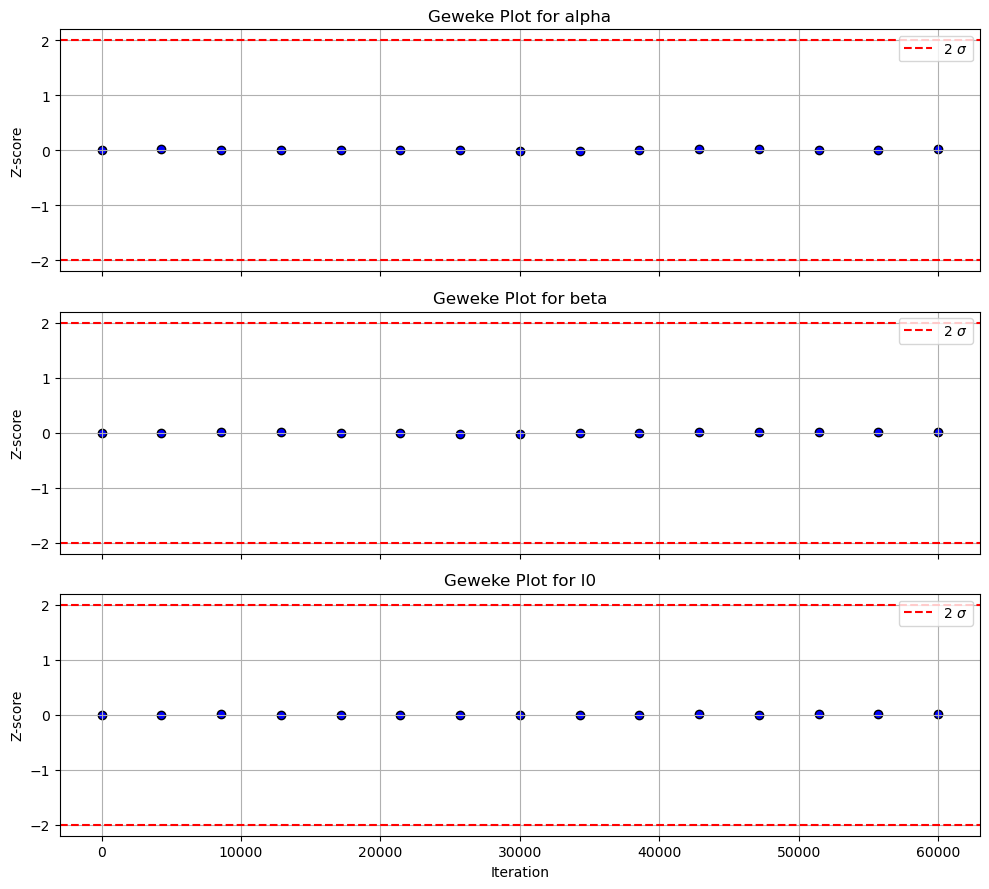

In [3]:
plotting_x(thinned_trace_x)

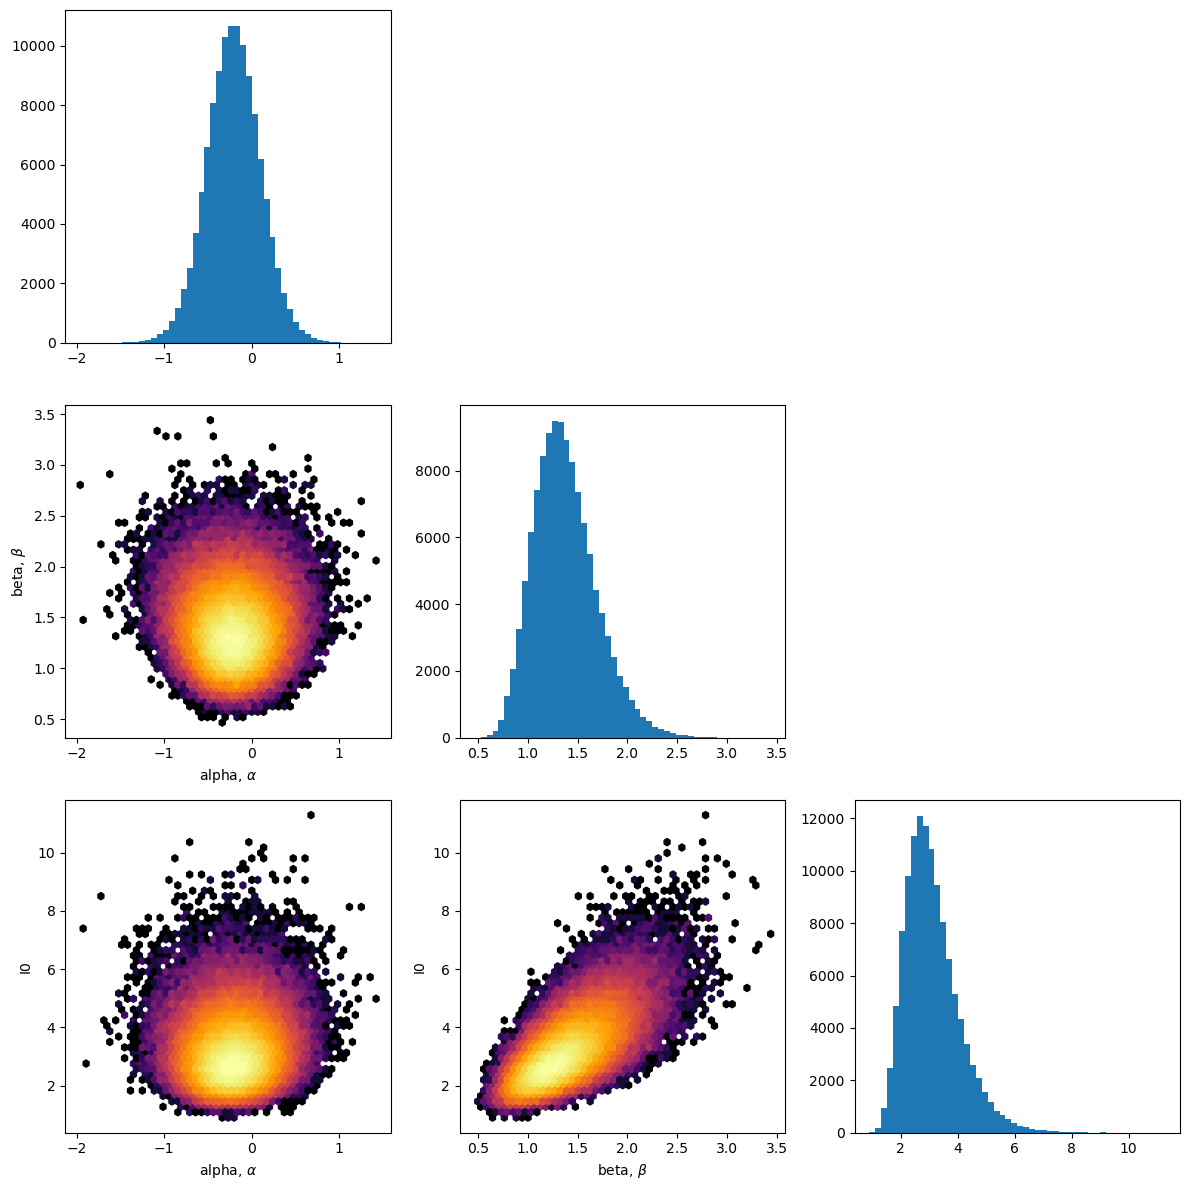

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.ticker import NullFormatter

def joint_posterior_x(trace):
    """
    Creates a series of 2D plots for each pair of variables.
    """
    # unpack trace
    alpha_samples = trace.posterior['alpha'].values.flatten()
    beta_samples = trace.posterior['beta'].values.flatten()
    I0_samples = trace.posterior['I0'].values.flatten()

    # Start figure
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # Adjust size as needed

    # Plot alpha vs beta
    axes[1, 0].hexbin(alpha_samples, beta_samples, gridsize=50, cmap='inferno', bins='log')
    axes[1, 0].set_xlabel(r'alpha, $\alpha$')
    axes[1, 0].set_ylabel(r'beta, $\beta$')

    # Plot alpha vs I0
    axes[2, 0].hexbin(alpha_samples, I0_samples, gridsize=50, cmap='inferno', bins='log')
    axes[2, 0].set_xlabel(r'alpha, $\alpha$')
    axes[2, 0].set_ylabel('I0')

    # Plot beta vs I0
    axes[2, 1].hexbin(beta_samples, I0_samples, gridsize=50, cmap='inferno', bins='log')
    axes[2, 1].set_xlabel(r'beta, $\beta$')
    axes[2, 1].set_ylabel('I0')

    # Histograms for alpha, beta, and I0
    axes[0, 0].hist(alpha_samples, bins=50, orientation='vertical')
 
    axes[1, 1].hist(beta_samples, bins=50, orientation='vertical')
  
    axes[2, 2].hist(I0_samples, bins=50, orientation='vertical')
 
    # Hide the empty subplots
    axes[0, 1].axis('off')
    axes[0, 2].axis('off')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
joint_posterior_x(thinned_trace_x)


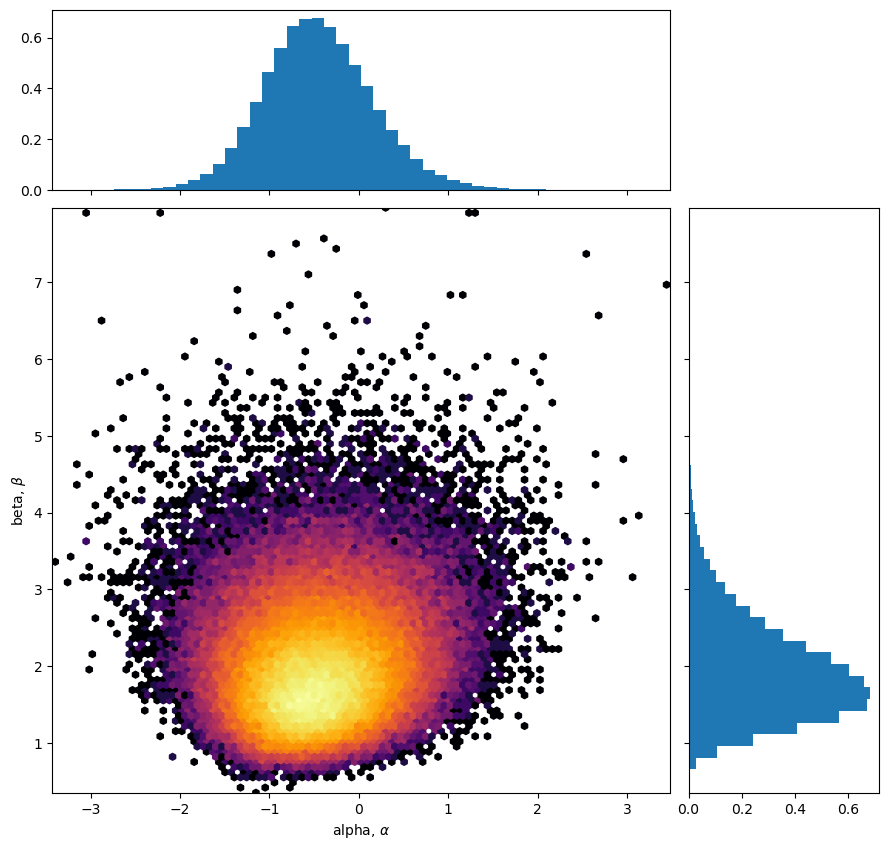

In [5]:
from matplotlib.ticker import NullFormatter

def joint_posterior_x(trace):
    """
    Plots the joint distribution of alpha and beta samples from a trace,
    with marginal histograms.
    """
    # Unpack trace
    alpha_samples = trace.posterior['alpha'].values.flatten()
    beta_samples = trace.posterior['beta'].values.flatten()

    nullfmt = NullFormatter()

    # Define axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # Start figure
    fig = plt.figure(figsize=(9.5, 9))

    # Scatter plot
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # No labels for histograms
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    # Scatter plot with hexbin
    hb = axScatter.hexbin(alpha_samples, beta_samples, gridsize=100, cmap='inferno', bins='log')

    # Set axis labels
    axScatter.set_xlabel(r'alpha, $\alpha$')
    axScatter.set_ylabel(r'beta, $\beta$')

    # Automatically determine nice limits
    axScatter.set_xlim((alpha_samples.min(), alpha_samples.max()))
    axScatter.set_ylim((beta_samples.min(), beta_samples.max()))

    # Marginal histograms
    axHistx.hist(alpha_samples, bins=50, density=True)
    axHisty.hist(beta_samples, bins=50, orientation='horizontal', density=True)

    # Set histogram limits to match the scatter plot
    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())

    plt.show()

joint_posterior_x(thinned_trace_x)


In [10]:
import pandas as pd

def convergence_diagnostic(thinned_trace):

    # Compute the mean and standard deviation for each parameter
    summary_stats = az.summary(thinned_trace, round_to=2)

    # Create a DataFrame to hold the results
    diagnostic_df = pd.DataFrame({
        'mean': summary_stats['mean'],
        'sd': summary_stats['sd'],
        'tau': summary_stats['ess_bulk'] / summary_stats['ess_mean'],
        'r_hat': summary_stats['r_hat']
    })

    # Print the DataFrame in a nice tabular format
    print(diagnostic_df)

convergence_diagnostic(thinned_trace_x)

       mean    sd       tau  r_hat
alpha -0.45  0.61  1.010992    1.0
beta   1.97  0.68  1.035364    1.0


In [21]:
alpha_samples = trace_x.posterior['alpha'].values
alpha_samples

array([[-0.79478675,  0.05753929, -1.3520983 , ..., -0.48031918,
        -0.60557772, -0.60557772],
       [-1.63121151,  0.05313707, -1.19944908, ..., -0.48030652,
        -0.55155415, -0.57911609],
       [-0.530121  , -0.32328604, -0.32328604, ..., -0.70878221,
        -0.03370548, -1.1154078 ],
       ...,
       [-0.89108353, -0.69173956,  1.04698325, ..., -0.68770023,
        -0.32042566, -0.43465909],
       [-0.8440777 , -0.56936777, -0.62118771, ...,  0.17100781,
        -0.8174886 , -0.3321593 ],
       [-0.19423114, -0.19423114, -0.86076017, ..., -0.93474287,
        -0.93474287, -1.67596495]])

In [6]:
# Read and prepare the data
x_observed, I_observed = read_and_prepare_data('lighthouse_flash_data.txt')

# Read the configuration file
model_params, sampling_params = read_config('parameters.ini')

# Define the models
model_x = define_model_x(x_observed, **model_params)
model_xi = define_model_xi(x_observed, I_observed, **model_params)


In [7]:
trace_x = sample_model(model_xi, **sampling_params)

Multiprocess sampling (8 chains in 4 jobs)
NUTS: [I0, beta, alpha]


Sampling 8 chains for 800 tune and 30_000 draw iterations (6_400 + 240_000 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.8925399244186415, but should be close to 0.8. Try to increase the number of tuning steps.


In [30]:
az.plot_trace(trace_x)
plt.show()

NameError: name 'trace_x' is not defined

In [5]:
var_names = list(trace_x.posterior.data_vars.keys())  

In [28]:
var_names

['alpha', 'beta', 'I0']

In [8]:
summary = az.summary(trace_x)
print(summary)

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean    ess_sd  \
alpha -0.451  0.608  -1.585    0.695      0.001    0.001  171408.0  128742.0   
beta   1.967  0.677   0.881    3.224      0.002    0.001  138033.0  115667.0   

       ess_bulk  ess_tail  r_hat  
alpha  175457.0  143634.0    1.0  
beta   149881.0  142788.0    1.0  


In [6]:
def marginal_posterior(trace, bins=50, figsize=(12, 8)):
    
    var_names = list(trace_x.posterior.data_vars.keys())
    
    # Obtain summary statistics using ArviZ
    summary = az.summary(trace, var_names=var_names, round_to=2)
    
    # Create subplots
    fig, axes = plt.subplots(len(var_names), 1, figsize=figsize, squeeze=False)
    
    for i, var_name in enumerate(var_names):
        # Extract samples
        samples = trace.posterior[var_name].values.flatten()
        
        # Extract summary statistics
        mean = summary.loc[var_name, 'mean']
        sd = summary.loc[var_name, 'sd']
        
        # Plot histogram
        axes[i, 0].hist(samples, bins=bins, density=True, alpha=0.6)
        axes[i, 0].axvline(mean, color='r', linestyle='-')
        axes[i, 0].axvline(mean + sd, color='r', linestyle='--')
        axes[i, 0].axvline(mean - sd, color='r', linestyle='--')
        axes[i, 0].set_xlabel(var_name)
        axes[i, 0].text(mean + 2*sd, plt.ylim()[1] * 0.5, fr'$\mu_{var_name}$ = {mean:.2f} $\pm$ {sd:.2f}', horizontalalignment='center', color='r')
        
    plt.tight_layout()
    plt.show()

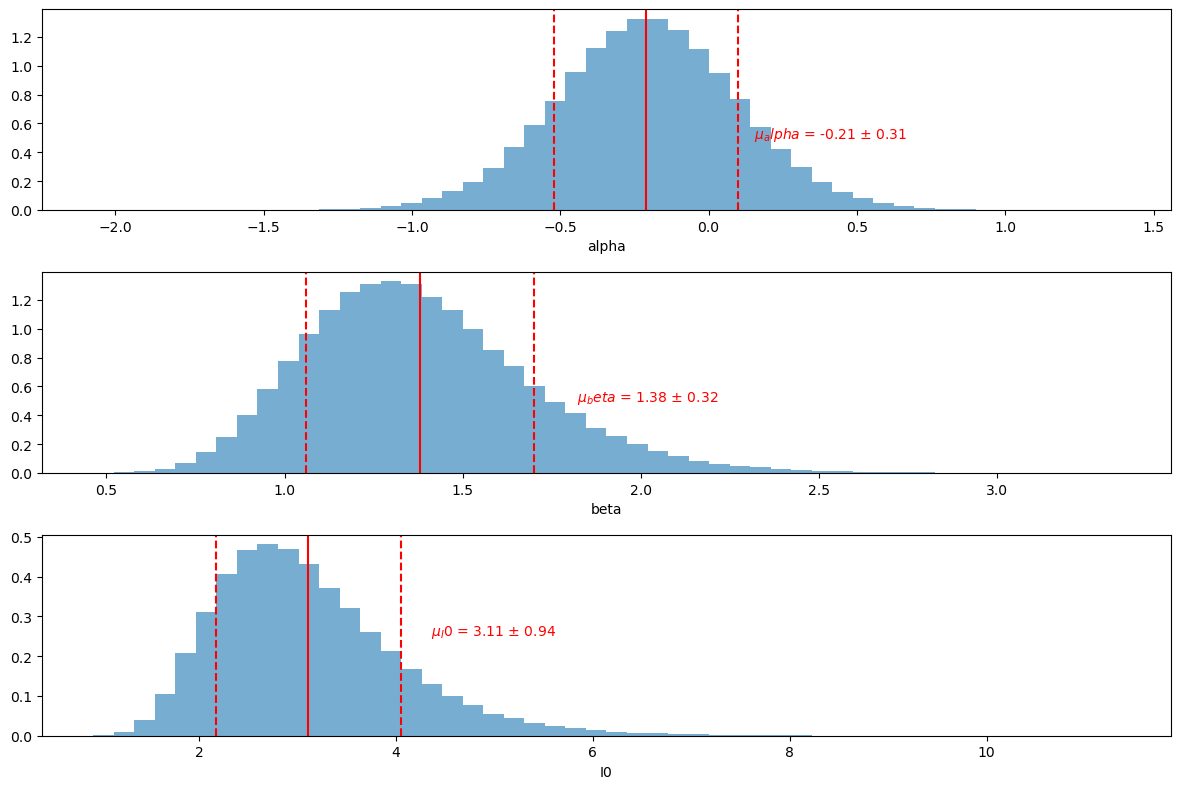

In [7]:
marginal_posterior(trace_x)

In [5]:
### Raftery Lewis
az.geweke(alpha_samples, intervals=15)


array([[ 0.00000000e+00,  6.69281009e-03],
       [ 8.57100000e+03,  5.94485692e-03],
       [ 1.71420000e+04,  2.84157491e-04],
       [ 2.57140000e+04, -3.08019872e-03],
       [ 3.42850000e+04,  2.19364273e-03],
       [ 4.28560000e+04,  5.21431663e-03],
       [ 5.14280000e+04,  3.29148152e-03],
       [ 5.99990000e+04, -2.88086588e-04],
       [ 6.85710000e+04,  3.44783796e-03],
       [ 7.71420000e+04,  1.19618664e-02],
       [ 8.57130000e+04,  6.96526665e-03],
       [ 9.42850000e+04, -3.08679231e-03],
       [ 1.02856000e+05, -2.71256545e-03],
       [ 1.11428000e+05, -8.09236797e-03],
       [ 1.19999000e+05, -2.55797474e-03]])

In [36]:
var_names = list(trace_x.posterior.data_vars)

In [37]:
var_names

['alpha', 'beta', 'I0']

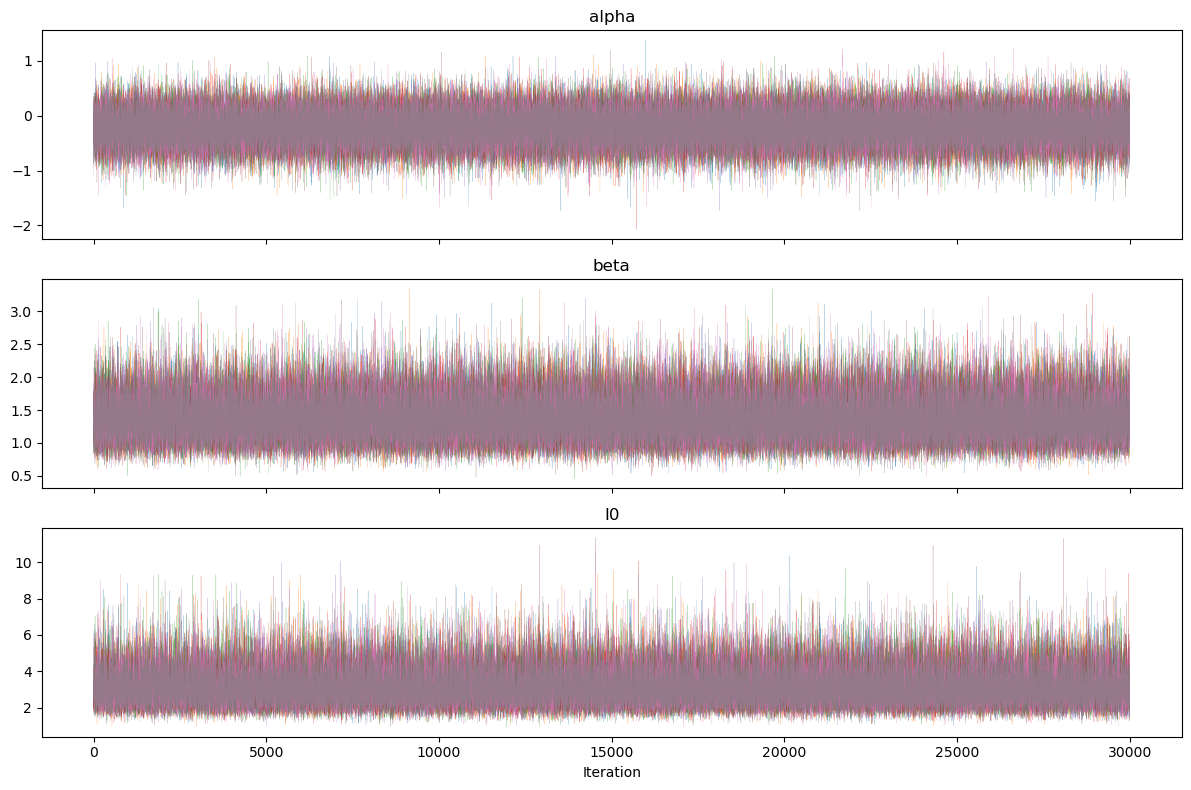

In [10]:
def plot_trace(trace, figsize=(12, 8)):

    # Extract variable names directly from the InferenceData object
    var_names = list(trace.posterior.data_vars)

    n_vars = len(var_names)
    fig, axes = plt.subplots(n_vars, 1, sharex=True, figsize=figsize, squeeze=False)

    for i, var_name in enumerate(var_names):
        # Extract samples, combining chains if there are multiple
        samples = trace.posterior[var_name].values

        # Plot trace for each chain
        for chain_samples in samples:
            axes[i, 0].plot(chain_samples, lw=0.15, alpha=0.7)

        axes[i, 0].set_title(var_name)

    # Set common labels
    axes[-1, 0].set_xlabel('Iteration')

    plt.tight_layout()
    plt.show()


plot_trace(trace_x)

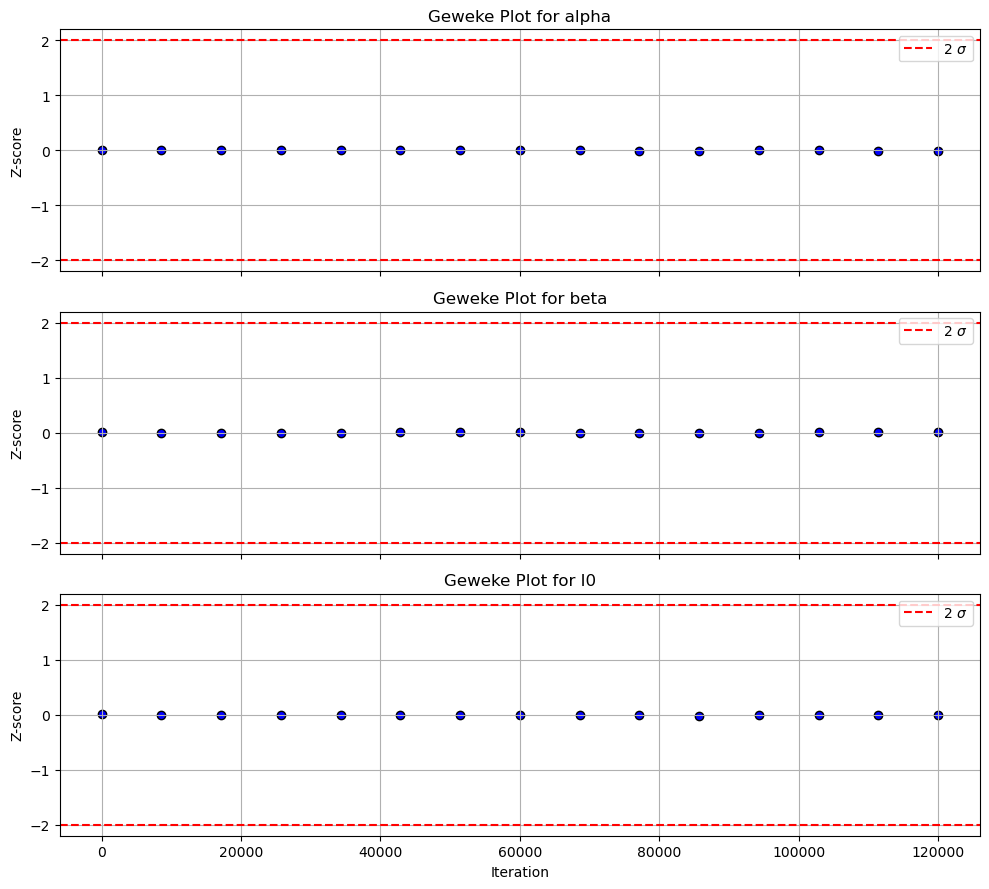

In [12]:
def plot_geweke(trace, intervals=15):
    """
    Plots the Geweke diagnostic for all variables in the given trace object.

    Parameters:
    - trace: The trace object from PyMC3 or InferenceData object.
    - intervals: Number of intervals to divide the sample chain for the Geweke diagnostic.
    """
    # Extract variable names directly from the InferenceData object
    var_names = list(trace.posterior.data_vars)
    
    # Determine the number of subplots needed
    n_vars = len(var_names)
    
    # Create subplots
    fig, axes = plt.subplots(n_vars, 1, figsize=(10, 3 * n_vars), sharex=True, squeeze=False)
    
    for i, var_name in enumerate(var_names):
        # Calculate Geweke diagnostic for each variable
        var_samples = trace.posterior[var_name].values.flatten()  # Flatten in case of multidimensional variables
        geweke_results = az.geweke(var_samples, intervals=intervals)
        
        # Extract iterations and z-scores
        iterations, z_scores = geweke_results[:, 0], geweke_results[:, 1]
        
        # Plot Geweke diagnostic
        axes[i, 0].scatter(iterations, z_scores, color='blue', edgecolor='k')
        axes[i, 0].axhline(y=2, color='r', linestyle='--', label=r'2 $\sigma$')
        axes[i, 0].axhline(y=-2, color='r', linestyle='--')
        axes[i, 0].set_ylabel('Z-score')
        axes[i, 0].set_title(f'Geweke Plot for {var_name}')
        axes[i, 0].grid(True)
        axes[i, 0].legend(loc='upper right')
        
    # Set common xlabel
    axes[-1, 0].set_xlabel('Iteration')

    plt.tight_layout()
    plt.show()

plot_geweke(trace_x)


In [40]:
def thin_trace_based_on_ess(trace):

    # Compute ESS for all variables
    ess_results = az.ess(trace)

    # Find the minimum ESS across all variables
    min_ess = ess_results.to_array().min().values.item()

    # Compute total number of samples (assuming all chains have the same length)
    total_samples = len(trace.posterior.draw) * len(trace.posterior.chain)

    # Calculate tau using the minimum ESS (to be conservative)
    tau = total_samples / min_ess
    print(f"The autocorrelation time (tau) based on min ESS is approximately: {tau:.2f}")

    # Calculate thinning interval as the ceiling of tau to ensure it's an integer to be consrtvative
    thinning_interval = int(np.ceil(tau))
    print(f"Thinning interval: {thinning_interval}")

    # Thin the trace by slicing with the thinning interval using xarray's isel method
    thinned_posterior = trace.posterior.isel(draw=slice(None, None, thinning_interval))

    # Create a new InferenceData object with the thinned posterior
    thinned_trace = az.InferenceData(posterior=thinned_posterior)
    
    return thinned_trace


thinned_trace_x = thin_trace_based_on_ess(trace_x)


The autocorrelation time (tau) based on min ESS is approximately: 2.07
Thinning interval: 3


In [53]:
joint_posterior_x(thinned_trace_x)

AttributeError: 'InferenceData' object has no attribute 'get_values'

In [8]:
# Assuming `trace` is your trace object from PyMC3 sampling
total_samples = len(trace) * trace.nchains  # Total number of samples

# Compute ESS for a specific parameter, say 'alpha'
ess_alpha = az.ess(trace['alpha'])
ess_beta = az.ess(trace['beta'])

# Calculate tau for 'alpha'
tau_alpha = total_samples / ess_alpha
tau_beta = total_samples / ess_beta

print(f"The autocorrelation time (tau) for 'alpha' is approximately: {tau_alpha}")
print(f"The autocorrelation time (tau) for 'beta' is approximately: {tau_beta}")

# tau
tau = tau_beta
print(tau)

thinned_trace = trace[::int(tau)]

num_samples = len(beta_samples)
print("Number of i.i.d. samples produced = {}".format(num_samples))
print("Time taken per i.i.d. sample = {}s".format((t_end-t_start)/num_samples))

# ESS 
ess = az.ess(trace)
print("Effective Sample Size (ESS):", ess)

# Assuming 'alpha_samples' is a NumPy array or a list of your alpha samples
num_alpha_samples = len(alpha_samples)
print("Number of alpha samples:", num_alpha_samples)

# percentage of samples ESS
print("Percentage of samples ESS:", ess/num_alpha_samples)

The autocorrelation time (tau) for 'alpha' is approximately: 1.8173460734703415
The autocorrelation time (tau) for 'beta' is approximately: 2.0110124436878936
2.0110124436878936
Number of i.i.d. samples produced = 240000
Time taken per i.i.d. sample = 0.0001215020755926768s


/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Effective Sample Size (ESS): <xarray.Dataset>
Dimensions:  ()
Data variables:
    alpha    float64 1.322e+05
    beta     float64 1.194e+05
Number of alpha samples: 240000
Percentage of samples ESS: <xarray.Dataset>
Dimensions:  ()
Data variables:
    alpha    float64 0.5507
    beta     float64 0.4975


In [26]:
thinned_trace = trace_x[::int(2)]


KeyError: slice(None, None, 2)

In [ ]:
# Calculate R-hat
r_hat = az.rhat(thinned_trace_x)
print('R-hat:', r_hat[0])


R-hat: <xarray.Dataset>
Dimensions:  ()
Data variables:
    alpha    float64 1.0
    beta     float64 1.0
    I0       float64 1.0


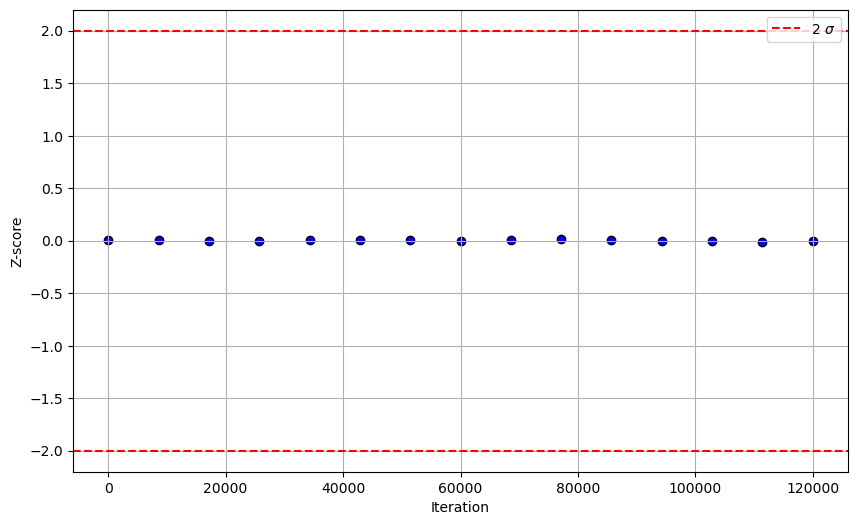

In [10]:
import matplotlib.pyplot as plt
import arviz as az

# Assuming `alpha_samples` is your MCMC samples for the parameter alpha
geweke_result = az.geweke(alpha_samples, intervals=15)

# geweke_result is an array of shape (n_intervals, 2) where the first column is the iteration and the second is the z-score
iterations = geweke_result[:, 0]
z_scores = geweke_result[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(iterations, z_scores, color='blue', edgecolor='k')

# Highlight the convergence range (-2, 2) for z-scores
plt.axhline(y=2, color='r', linestyle='--', label=r'2 $\sigma$')
plt.axhline(y=-2, color='r', linestyle='--')

plt.xlabel('Iteration')
plt.ylabel('Z-score')

plt.grid(True)
plt.legend()
plt.show()


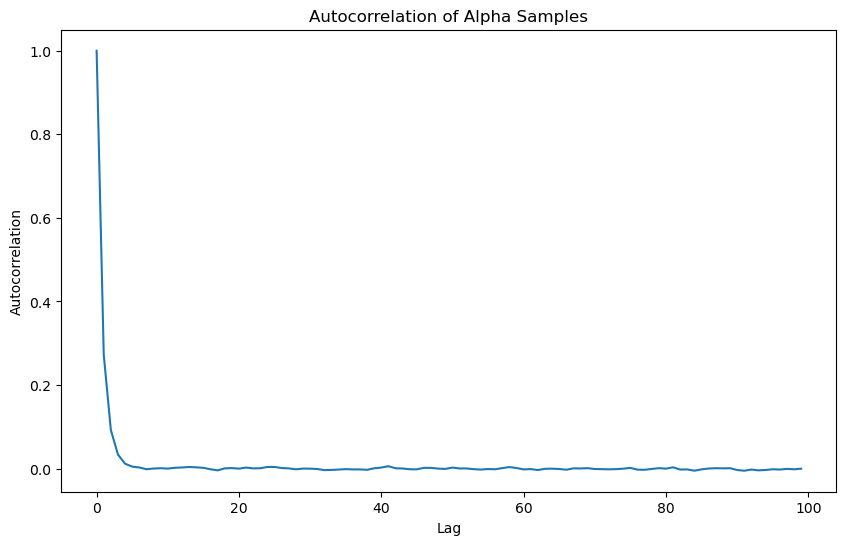

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def autocorr(x, lags):
    """Compute the autocorrelation of the signal, based on the properties of the
    power spectral density of the signal."""
    n = len(x)
    x = x - np.mean(x)
    r = np.correlate(x, x, mode='full')[-n:]
    assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r / (np.var(x) * np.arange(n, 0, -1))
    return result[:lags]

# Assuming alpha_samples is your samples array with shape (num_samples,)
lags = 100  # Choose the number of lags for which you want to compute autocorrelation
alpha_autocorr = autocorr(alpha_samples, lags)

# Plotting the autocorrelation
plt.figure(figsize=(10, 6))
plt.plot(alpha_autocorr)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Alpha Samples')
plt.show()


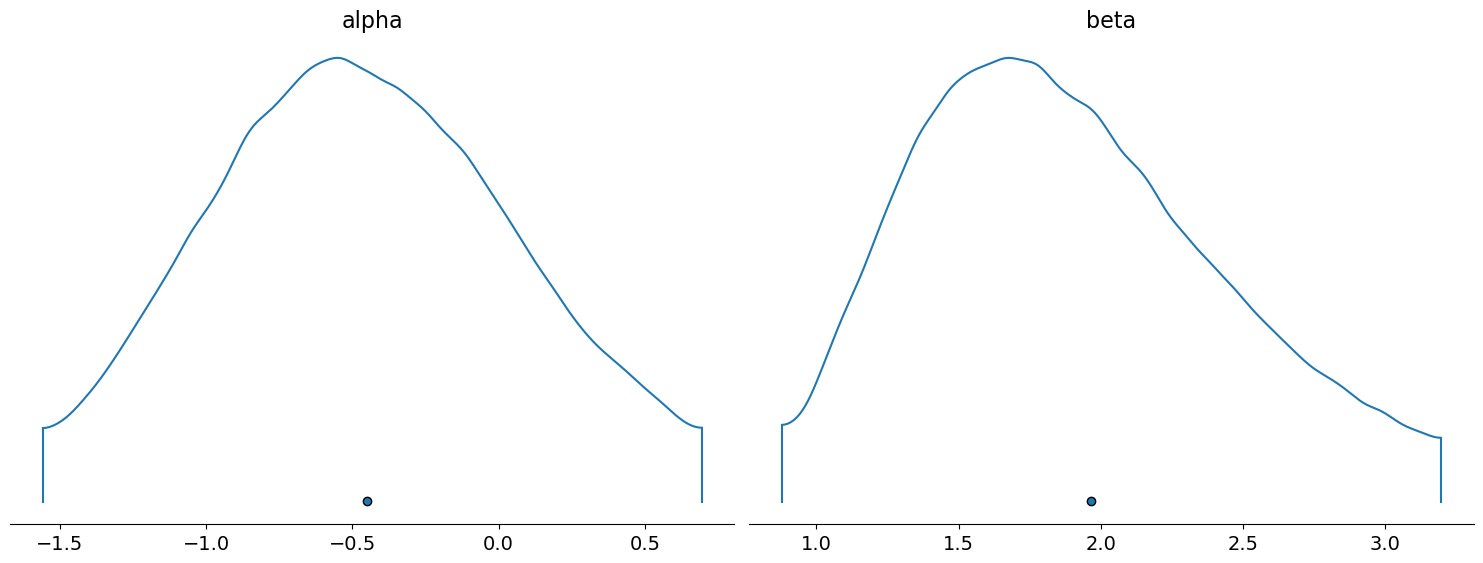

In [12]:
az.plot_density(trace)
plt.show()

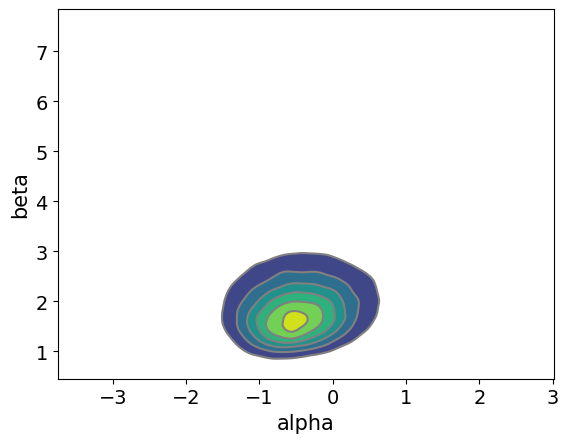

In [13]:
az.plot_pair(trace, kind='kde')
plt.show()

In [14]:
# Summary statistics
summary = az.summary(trace)
print(summary)

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean    ess_sd  \
alpha -0.451  0.601  -1.561    0.696      0.002    0.001  130622.0  121837.0   
beta   1.964  0.664   0.877    3.197      0.002    0.001  114486.0  110550.0   

       ess_bulk  ess_tail  r_hat  
alpha  132173.0  135064.0    1.0  
beta   119393.0  138467.0    1.0  


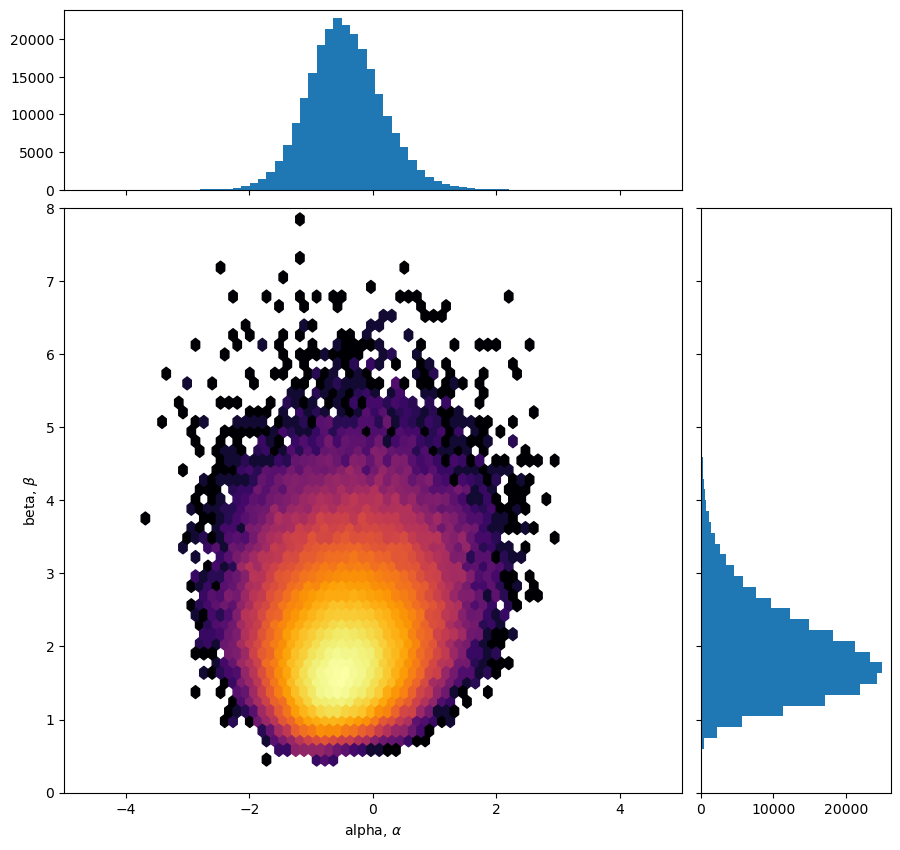

In [15]:
samples_flat = alpha_samples, beta_samples
xrange = a, b
yrange = c, d
plotv1(samples_flat, xrange, yrange)

In [1]:
plotv2(samples_flat, xrange, yrange)

NameError: name 'plotv2' is not defined

In [25]:
# observed flashes
I_observed = np.array(read_data(file_path)[1], dtype=np.float32)

# Constants for the uniform prior
a, b = -3, 2.5  # Bounds for alpha
c, d = 0.5, 8  # Bounds for beta
e, f = 0.5, 10  # Bounds for gamma


# Parameters for the MCMC sampler
num_chains = 8

In [26]:
import theano.tensor as tt

with pm.Model() as model:
    # Priors for model parameters alpha, beta, and I0
    alpha = pm.Uniform('alpha', lower=a, upper=b)
    beta = pm.Uniform('beta', lower=c, upper=d)
    I0 = pm.Exponential('I0', lam=1)

    # Likelihood for x_observed (flash locations)
    x_likelihood = pm.Cauchy('x_likelihood', alpha=alpha, beta=beta, observed=x_observed)

    # Likelihood for I_observed (Intensities)
    d = tt.sqrt(beta**2 + (x_observed - alpha)**2)
    mu = tt.log(I0) - 2 * tt.log(d)
    I_likelihood = pm.Lognormal('I_likelihood', mu=mu, sigma=1, observed=I_observed)
    
# Proceed with sampling
with model:
    trace = pm.sample(10000, tune=500, target_accept=0.95)  # Adjust these values as needed


/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [I0, beta, alpha]


/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 500 tune and 10_000 draw iterations (2_000 + 40_000 draws total) took 11 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'I0'}>, <Axes: title={'center': 'I0'}>]],
      dtype=object)

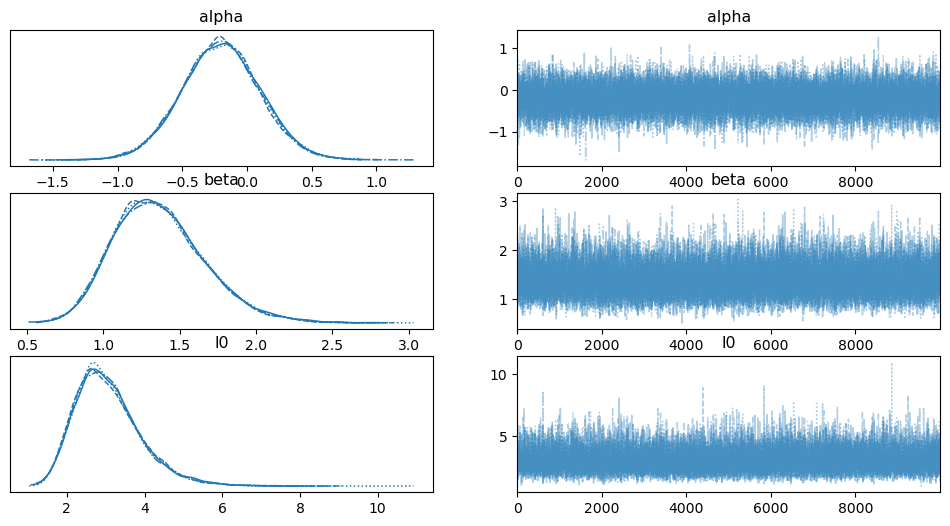

In [27]:
az.plot_trace(trace)

In [28]:
# Summary statistics
summary = az.summary(trace)
print(summary)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha -0.204  0.303  -0.782    0.361      0.002    0.002   23543.0   21795.0   
beta   1.367  0.299   0.846    1.942      0.002    0.001   20982.0   19760.0   
I0     3.055  0.846   1.620    4.640      0.006    0.004   21508.0   22412.0   

       r_hat  
alpha    1.0  
beta     1.0  
I0       1.0  
